Name: Tushar Muley
Assignment: Exercises 10-1
Date: 25 October 2020

In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import random

import thinkstats2
import thinkplot

In [8]:
import first
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ages = live.agepreg
weights = live.totalwgt_lb

In [9]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

In [9]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

In [20]:
def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)

In [35]:
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True)

In [23]:
def SamplingDistributions(live, iters=101):
    t = []
    for _ in range(iters):
        sample = ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = LeastSquares(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

In [12]:
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

**Exercise:** Use `ResampleRows` and generate a list of estimates for the mean birth weight.  Use `Summarize` to compute the SE and CI for these estimates.

In [13]:
iters = 1000
estimates = [ResampleRows(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.2656926933502985 0.014936630010032077 (7.241563398982076, 7.290060024341669)


In [29]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

In [15]:
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

In [37]:
class SlopeTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        ages, weights = data
        _, slope = thinkstats2.LeastSquares(ages, weights)
        return slope

    def MakeModel(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar

    def RunModel(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights

In [34]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

# Exercises

**Exercise:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

Read the BRFSS data and extract heights and log weights.

In [5]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

Estimate intercept and slope.

In [135]:
inter, slope = LeastSquares(heights, log_weights)
inter, slope

(0.9930804163917814, 0.005281454169417991)

Make a scatter plot of the data and show the fitted line.

In [93]:
fit_xs, fit_ys = FitLine(heights, inter, slope)

In [84]:
heights

0         157.0
1         163.0
3         170.0
4         185.0
5         183.0
          ...  
414504    191.0
414505    170.0
414506    178.0
414507    157.0
414508    178.0
Name: htm3, Length: 395832, dtype: float64

In [27]:
log_weights

0         1.850707
1         1.861714
3         1.867114
4         1.947630
5         2.037785
            ...   
414504    1.947630
414505    1.861714
414506    1.958612
414507    1.949829
414508    1.875061
Name: wtkg2, Length: 395832, dtype: float64

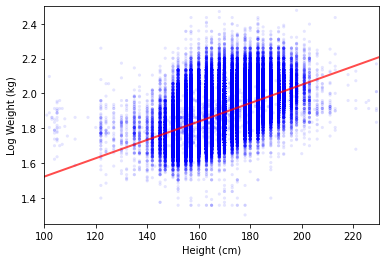

In [87]:
thinkplot.Scatter(heights, log_weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Height (cm)",
                 ylabel='Log Weight (kg)',
                 axis=[100,230, 1.25, 2.5],
                 legend=False)


Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

In [102]:
inter, slope = LeastSquares(heights, weights)

In [103]:
fit_xs, fit_ys = FitLine(heights, inter, slope)

In [104]:
weights

0          70.91
1          72.73
3          73.64
4          88.64
5         109.09
           ...  
414504     88.64
414505     72.73
414506     90.91
414507     89.09
414508     75.00
Name: wtkg2, Length: 395832, dtype: float64

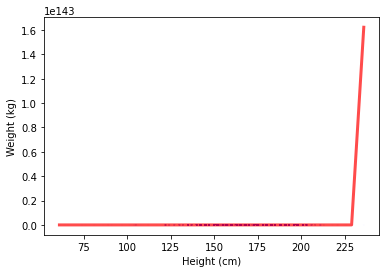

In [106]:
thinkplot.Scatter(heights, weights, color='blue', alpha=0.01, s=5)
fit_xs, fit_ys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fit_xs, 10**fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Height (cm)",
                 ylabel='Weight (kg)',
                 legend=False)

Plot percentiles of the residuals.

In [30]:
res = Residuals(heights, log_weights, inter, slope)
df['residual'] = res

In [137]:
df.columns

Index(['age', 'sex', 'wtyrago', 'finalwt', 'wtkg2', 'htm3', 'residual'], dtype='object')

In [125]:
df['residual'] = Residuals(heights, log_weights, inter, slope)

In [138]:
df.residual

0         0.028439
1         0.007756
3        -0.023814
4        -0.022520
5         0.078198
            ...   
414504   -0.054208
414505   -0.029214
414506    0.025432
414507    0.127560
414508   -0.058118
Name: residual, Length: 395832, dtype: float64

In [139]:
df.htm3

0         157.0
1         163.0
3         170.0
4         185.0
5         183.0
          ...  
414504    191.0
414505    170.0
414506    178.0
414507    157.0
414508    178.0
Name: htm3, Length: 395832, dtype: float64

In [144]:
bins = np.arange(130, 230, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

height_means = [group.htm3.mean() for _, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]


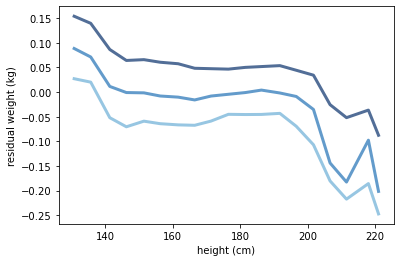

In [145]:
thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(height_means, ys, label=label)
    
thinkplot.Config(xlabel='height (cm)', ylabel='residual weight (kg)', legend=False)

In [ ]:
# The lines are similar over the range, so the relationship is linear. 
# lines mirror each other indicating the variance is the same. There is a dip in the 25 percent line at around 
# 140 cm. Than 25 percent line and 50 percent lines come close near 200 - 210 cm.



Compute correlation.

In [149]:
correlation = thinkstats2.Corr(heights, log_weights)
correlation

0.5317282605983575

Compute coefficient of determination.

In [151]:
rsquared = thinkstats2.CoefDetermination(log_weights, res)
rsquared

0.2827349431189319

Confirm that $R^2 = \rho^2$.

In [153]:
correlation**2 - rsquared

2.2926105458509483e-14

Compute Std(ys), which is the RMSE of predictions that don't use height.

In [21]:
#I did weights for both log and non log
print('Std(ys)', Std(weights))
print('Std(res)', Std(res))
print('Std(log_ys)', Std(log_weights))

Std(ys) 1.40821553384062
Std(res) 0.15374446385331794
Std(log_ys) 0.10320725030004863


Compute Std(res), the RMSE of predictions that do use height.

In [32]:
std_res = Std(res)
std_res

0.15374446385331794

How much does height information reduce RMSE?

In [29]:
#Had to redo std_ys not save from before
std_ys = Std(log_weights)
std_ys

0.10320725030004863

In [33]:
1 - std_res / std_ys


-0.4896672802186408

Use resampling to compute sampling distributions for inter and slope.

In [36]:
t = []
for _ in range(100):
    sample = ResampleRows(df)
    estimates = LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

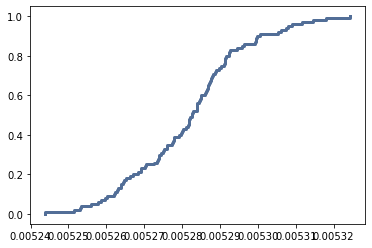

In [39]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

Compute the p-value of the slope.

In [40]:
print('pvalue',cdf[0])

pvalue 0


Compute the 90% confidence interval of slope.

In [42]:
print('5%=', cdf.Percentile(5),'95%=', cdf.Percentile(95))


5%= 0.005255980606518346 95%= 0.005308070412706934


Compute the mean of the sampling distribution.

In [44]:
print ('mean of slope=', Mean(slopes))

mean of slope= 0.005281747081768061


Compute the standard deviation of the sampling distribution, which is the standard error.

In [45]:
print('std of slope=',Std(slopes))

std of slope= 1.532071968312446e-05


Resample rows without weights, compute mean height, and summarize results.

In [47]:
estimatesUnweight =[ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimatesUnweight)

mean, SE, CI 168.95748352836554 0.0180212595000463 (168.92709280704946, 168.98716374623578)


Resample rows with weights.  Note that the weight column in this dataset is called `finalwt`.

In [63]:
df

,age,sex,wtyrago,finalwt,wtkg2,htm3,residual
0,82.0,2,76.363636,185.870345,70.91,157.0,-7.719944
1,65.0,2,72.727273,126.603027,72.73,163.0,-7.813661
3,61.0,1,73.636364,517.926275,73.64,170.0,-7.930438
4,26.0,1,88.636364,1252.624630,88.64,185.0,-8.111730
5,42.0,1,118.181818,415.161314,109.09,183.0,-7.986667
...,...,...,...,...,...,...,...
414504,23.0,1,84.090909,43.439320,88.64,191.0,-8.216453
414505,49.0,2,70.454545,6.216538,72.73,170.0,-7.935838
414506,45.0,1,86.363636,20.617560,90.91,178.0,-7.978571
414507,52.0,2,89.090909,11.188138,89.09,157.0,-7.620823


In [71]:
estimatesWeight = [ResampleRowsWeighted(df,'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimatesWeight)

mean, SE, CI 170.49673624163788 0.016232847457105955 (170.47343064734534, 170.5242653448938)


In [ ]:
#The mean hieight is 2 cm taller.